In [1]:
# Core analysis packages

from pandas import ExcelWriter
from pandas import ExcelFile
from statsmodels.formula.api import ols
import pingouin as pg
# import researchpy

import numpy as np
import os, sys
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import anova
from patsy import dmatrices
import bff
# Plotting packages
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns 
sns.set(style="ticks", color_codes=True)
sns.set_style("white")
sns.set_style({'xtick.bottom': True, 'ytick.left': True})
colorref = ["gray", "royalblue", "crimson", "goldenrod", "mediumorchid", "seagreen"]

# iPython magic commands
%matplotlib notebook
%load_ext autoreload
%autoreload 2

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIG_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)  # fontsize of the figure title

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from uszipcode import SearchEngine

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.mpl.rc("figure", figsize=(12,8))
%matplotlib inline 

/opt/anaconda3/envs/research/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [45]:
# Read the shapes from the shapefile into a list of shapely geometries.
shapename = 'admin_1_states_provinces_lakes'
states_shp = shpreader.natural_earth(resolution='110m',
                                     category='cultural', name=shapename)

/opt/anaconda3/envs/research/lib/python3.6/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_1_states_provinces_lakes.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


In [39]:
# Load file (from same directory as the notebook)
df = pd.read_excel(("PolicybyState.xlsx"), index_col=0)
df.head()

,ZIP,policy
ID,,
201,90046,88.333333
202,46808,64.666667
203,33068,42.777778
204,38824,61.444444
205,90012,85.666667


In [40]:
# DEBUG: Search for invalid zipcodes
for Z in df.ZIP.unique():
    try:
        search.by_zipcode(Z).state
    except:
        print(Z)

74742


In [41]:
# Exclude invalid zipcodes— 74742
df = df.loc[~df.ZIP.isin(["74742"]), :]

In [42]:
# Convert ZIP codes to string
df["ZIP"] = df["ZIP"].astype("str")
df['ZIP'] = df['ZIP'].apply('{0:0>5}'.format)
# Convert ZIP codes to state
search = SearchEngine()
fn = lambda Z: search.by_zipcode(Z).state
if "ZIPstate" in df.columns:
    df.drop("ZIPstate", axis=1, inplace=True)
df.insert(1, "ZIPstate", list(map(fn, df["ZIP"])))
# Drop any participants whose ZIP did not turn a match
# df = df[df['ZIPstate'].notnull()]

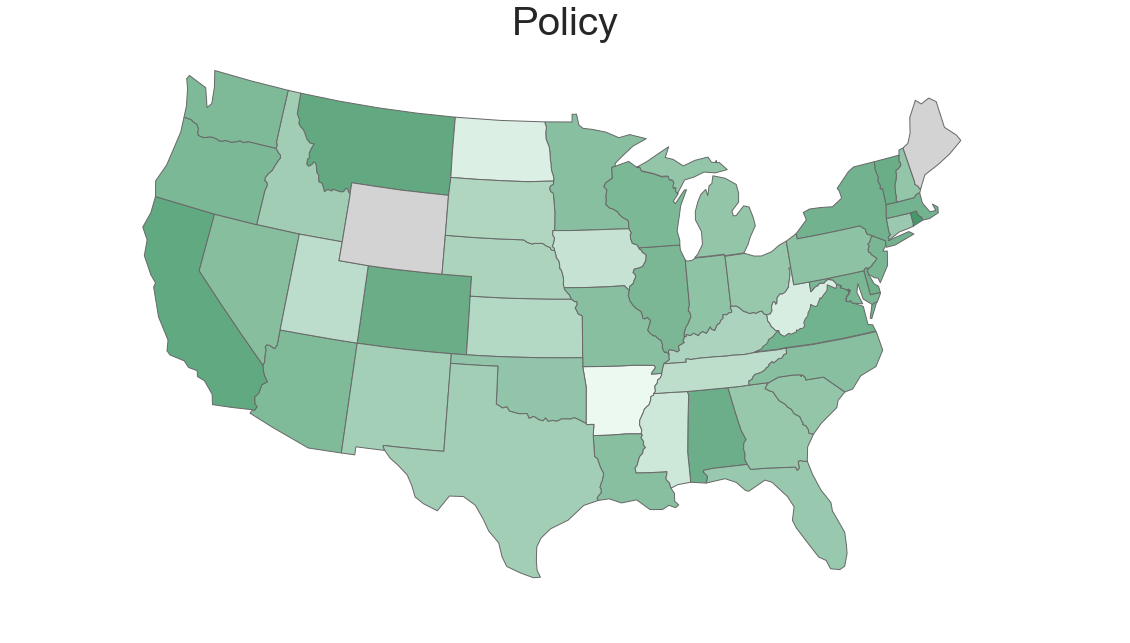

<Figure size 432x288 with 0 Axes>

In [87]:
ofinterest = "policy"
pal = sns.light_palette("seagreen", as_cmap=True)

DATA = df.groupby(["ZIPstate"]).mean()
minval, maxval = DATA[ofinterest].min(), DATA[ofinterest].max()

# Create the mpl axes of a PlateCarree map
plt.figure(figsize=(20,15))
ax = plt.axes(projection=ccrs.LambertConformal())
ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)
ax.set_title(ofinterest.title(), fontsize=40)

for astate in shpreader.Reader(states_shp).records():

    edgecolor = 'dimgray'

    try:
        # use the name of this state to get pop_density
        facecolor = pal(1. * (DATA.loc[astate.attributes["postal"], ofinterest] - minval) / (maxval-minval))
    except:
        facecolor = "lightgray"

    ax.add_geometries([astate.geometry], ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor=edgecolor)

plt.show()
plt.savefig('USpolicymap.png', dpi=300, format="png")

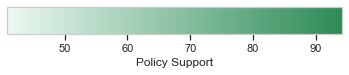

In [83]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

norm = mpl.colors.Normalize(vmin=minval, vmax=maxval)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=pal,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Policy Support')
plt.savefig('maplegend.png', dpi=600, format="png")